In [1]:
# common imports
import numpy as np
import os
import sklearn
import pandas as pd
import pickle

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
import lightgbm as lgb
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

import xgboost
from xgboost import XGBRFClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline


# to make this notebook's output stable across runs
np.random.seed(4)

# to plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
pipeline = pickle.load(open('../model/best_ensemble_model','rb'))

model = pipeline[1]

train = pd.read_csv('../data/train_newfeats_drop.csv')

In [4]:
X = train.drop(['Cover_Type'], axis= 1)
y = train['Cover_Type']

transformer = QuantileTransformer()

trans_X = transformer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
model.fit(X_train, y_train)

y_test_pred_model = model.predict(X_test)

print (model.score(X_train, y_train))
print(model.score(X_test, y_test))

1.0
0.8898809523809523


In [9]:
print(classification_report(y_test, y_test_pred_model))

              precision    recall  f1-score   support

           1       0.81      0.80      0.80       421
           2       0.81      0.72      0.76       438
           3       0.89      0.87      0.88       428
           4       0.94      0.99      0.97       449
           5       0.91      0.96      0.94       416
           6       0.88      0.91      0.89       432
           7       0.96      0.99      0.97       440

    accuracy                           0.89      3024
   macro avg       0.89      0.89      0.89      3024
weighted avg       0.89      0.89      0.89      3024



In [10]:
print(accuracy_score(y_test, y_test_pred_model))
print(precision_score(y_test, y_test_pred_model, average='macro'))
print(recall_score(y_test, y_test_pred_model, average='macro'))
print(f1_score(y_test, y_test_pred_model, average='macro'))

0.8898809523809523
0.8871867375802119
0.8894256219098847
0.8877289094737442


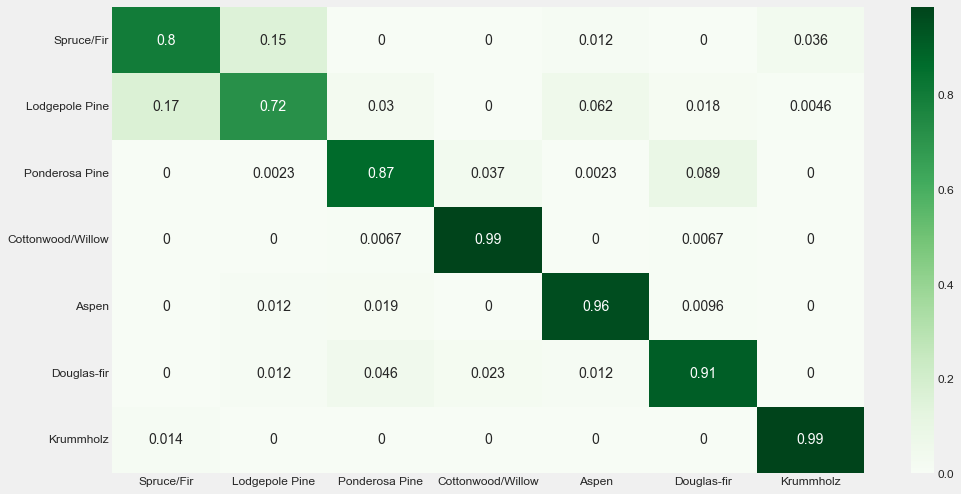

In [11]:
x_axis_labels = ['Spruce/Fir','Lodgepole Pine','Ponderosa Pine','Cottonwood/Willow','Aspen','Douglas-fir','Krummholz'] 
y_axis_labels = ['Spruce/Fir','Lodgepole Pine','Ponderosa Pine','Cottonwood/Willow','Aspen','Douglas-fir','Krummholz'] 

plt.figure(figsize = (15,8))
sns.heatmap(confusion_matrix(y_test, y_test_pred_model, normalize='true'), annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap='Greens');

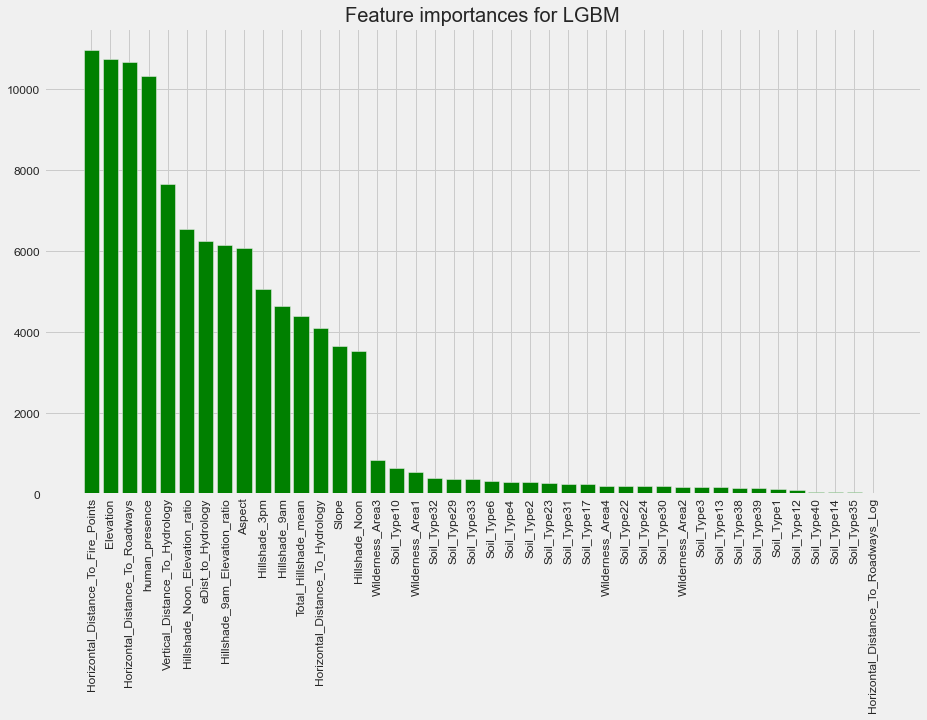

In [15]:
importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize = (14,8))

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#008000')
plt.title('Feature importances for LGBM', size=20)
plt.xticks(rotation='vertical')
plt.show()